# Notebook 3: Pipeline Validation and Comparison with MIA

This notebook validates an AI-assisted pipeline for automated extrachromosomal DNA (ecDNA) detection in fluorescence in situ hybridization (FISH) images. Using optimal hyperparameters derived from Bayesian optimization (see Supplementary Notebook 1), we:

- Apply the finalized pipeline to a dataset of 388 annotated FISH images.
- Compare predicted ecDNA counts with manual annotations (ground truth) and predictions from the MIA method.
- Compute performance metrics: Median Absolute Percentage Error (MdAPE) and Pearson correlation coefficient.
- Perform statistical comparisons between the pipeline and MIA.
- Visualize results to assess accuracy and error distribution.

The pipeline enhances small bright features (ecDNA) while suppressing larger structures (chromosomes), leveraging morphological operations, contrast adjustment, and object detection. This notebook demonstrates its practical utility and superiority over MIA, supporting its application in ecDNA research.

### Dependencies

The following Python libraries are required. Specific versions ensure reproducibility:

- `opencv-python==4.11.0.86`: Image processing.
- `numpy==1.26.4`: Numerical operations.
- `pandas==2.1.4`: Data handling.
- `matplotlib==3.8.4`: Plotting.
- `seaborn==0.13.2`: Enhanced visualization.
- `scipy==1.13.1`: Statistical tests.

Install via:

`pip install opencv-python==4.11.0.86 numpy==1.26.4 pandas==2.1.4 matplotlib==3.8.4 seaborn==0.13.2 scipy==1.13.1`

### Import and Utility Setup

In [1]:
import os
import cv2
import json
import math
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from concurrent.futures import ProcessPoolExecutor, as_completed
from scipy.stats import wilcoxon


### Utility Functions

##### Utility functions (e.g., process_images, object_detection_and_overlay) were defined in Supplementary Notebook 1 (Optimization).
##### They are reused here for evaluation and visualization purposes.

In [2]:
def extract_unique_id(filename, suffixes):
    """Extract the base unique ID from a filename by removing suffixes.

    Args:
        filename (str): Filename to process.
        suffixes (list): List of suffixes to strip.

    Returns:
        str: Base unique ID.
    """
    base = os.path.splitext(filename)[0]
    for suf in suffixes:
        if base.endswith(suf):
            return base[:-len(suf)]
    return base

def find_corresponding_dapi(unique_id, dapi_folder):
    """Locate the corresponding DAPI image for a given unique ID.

    Args:
        unique_id (str): Unique identifier of the image.
        dapi_folder (str): Directory containing DAPI images.

    Returns:
        str or None: Path to DAPI image if found, else None.
    """
    dapi_suffixes = ["_DAPI", "_DAPI.tif", "_Merge.tif (RGB)", "_Merge.tif(RGB)",
                     "_Merge.tif (RGB).tif", "_Merge.tif(RGB).tif"]
    for fname in os.listdir(dapi_folder):
        if not fname.lower().endswith(('.tif', '.tiff', '.png')):
            continue
        uid = extract_unique_id(fname, dapi_suffixes)
        if uid == unique_id:
            return os.path.join(dapi_folder, fname)
    return None

def mask_rgb_with_dapi(rgb_img, dapi_img):
    """Mask RGB image regions where DAPI intensity is zero to focus on nuclei.

    Args:
        rgb_img (np.ndarray): RGB image.
        dapi_img (np.ndarray): DAPI grayscale image.

    Returns:
        np.ndarray: Masked RGB image.
    """
    if len(dapi_img.shape) != 2:
        dapi_img = cv2.cvtColor(dapi_img, cv2.COLOR_BGR2GRAY)
    mask = (dapi_img == 0)
    rgb_masked = rgb_img.copy()
    rgb_masked[mask] = 0
    return rgb_masked

def top_hat_enhancement(gray, kernel_size=20, chrom_kernel_size=200, dampening_factor=0.6):
    """Enhance small bright features (ecDNA) while suppressing large structures (chromosomes).

    Args:
        gray (np.ndarray): Grayscale image.
        kernel_size (float): Size of structuring element for top-hat.
        chrom_kernel_size (float): Size for chromosome suppression.
        dampening_factor (float): Intensity reduction factor for chromosomes (0-1).

    Returns:
        np.ndarray: Enhanced image.
    """
    se = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (int(kernel_size), int(kernel_size)))
    opened = cv2.morphologyEx(gray, cv2.MORPH_OPEN, se)
    top_hat = cv2.subtract(gray, opened)
    top_hat_norm = cv2.normalize(top_hat, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    chrom_se = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (int(chrom_kernel_size), int(chrom_kernel_size)))
    chromosome_est = cv2.morphologyEx(gray, cv2.MORPH_CLOSE, chrom_se)
    _, chrom_mask = cv2.threshold(chromosome_est, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    top_hat_soft = top_hat_norm.astype(np.float32)
    top_hat_soft[chrom_mask == 255] *= dampening_factor
    return np.clip(top_hat_soft, 0, 255).astype(np.uint8)

def custom_clahe(gray, clip_limit, tile_grid_size):
    """Apply Contrast Limited Adaptive Histogram Equalization.

    Args:
        gray (np.ndarray): Grayscale image.
        clip_limit (float): Contrast limit.
        tile_grid_size (float): Size of grid tiles.

    Returns:
        np.ndarray: Enhanced image.
    """
    tile_size = (int(tile_grid_size), int(tile_grid_size))
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_size)
    return clahe.apply(gray)

def apply_sharpening_gray(gray, strength):
    """Sharpen the image to enhance ecDNA edges.

    Args:
        gray (np.ndarray): Grayscale image.
        strength (float): Sharpening intensity.

    Returns:
        np.ndarray: Sharpened image.
    """
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]], dtype=np.float32) * (strength / 5.0)
    return cv2.filter2D(gray, -1, kernel)

def apply_sigmoid(gray, cutoff, gain):
    """Apply sigmoid transformation for contrast enhancement.

    Args:
        gray (np.ndarray): Grayscale image.
        cutoff (float): Sigmoid midpoint.
        gain (float): Sigmoid steepness.

    Returns:
        np.ndarray: Enhanced image.
    """
    norm = gray.astype(np.float32) / 255.0
    c = cutoff / 255.0
    out = 1.0 / (1.0 + np.exp(-gain * (norm - c)))
    return (out * 255).astype(np.uint8)

def process_images(input_image, params):
    """Process an image through the enhancement pipeline.

    Note: Sharpening precedes CLAHE to enhance ecDNA edges before contrast adjustment,
    based on empirical tuning showing improved detection sensitivity.

    Args:
        input_image (np.ndarray): Input RGB or grayscale image.
        params (dict): Hyperparameters for processing.

    Returns:
        tuple: (simple_gray, enhanced) - original grayscale and enhanced images.
    """
    if input_image.ndim == 3:
        gray = cv2.cvtColor(cv2.convertScaleAbs(input_image), cv2.COLOR_BGR2GRAY)
    else:
        gray = cv2.convertScaleAbs(input_image)
    simple_gray = gray.copy()
    th = top_hat_enhancement(gray, params['kernel_size'], params['chrom_kernel_size'], params['dampening_factor'])
    sharp = apply_sharpening_gray(th, params['strength'])
    clahe_img = custom_clahe(sharp, params['clip_limit'], params['tile_grid_size'])
    enhanced = apply_sigmoid(clahe_img, params['cutoff'], params['gain'])
    return simple_gray, enhanced


# Define the single-image processing function for parallelization

def process_single_image(row, best_params, rgb_folder, dapi_folder):
    """Process a single image and compute its counts and errors.

    Args:
        row (pd.Series): Row from merged_df with image data.
        best_params (dict): Optimized hyperparameters.
        rgb_folder (str): RGB image directory.
        dapi_folder (str): DAPI image directory.

    Returns:
        dict: Results for this image.
    """
    base_id = row["base_id"]
    true_count = row["ground_truth_count"]
    mia_count = row["Count"]
    rgb_path = os.path.join(rgb_folder, f"{base_id}_Merge(RGB).tif")
    dapi_path = find_corresponding_dapi(base_id, dapi_folder)

    if not os.path.exists(rgb_path):
        print(f"Warning: RGB image {rgb_path} not found, setting count to 0")
        predicted_count = 0
    else:
        rgb_img = cv2.imread(rgb_path, cv2.IMREAD_COLOR)
        if rgb_img is None:
            print(f"Error: Failed to load {rgb_path}, setting count to 0")
            predicted_count = 0
        else:
            if dapi_path and (dapi_img := cv2.imread(dapi_path, cv2.IMREAD_GRAYSCALE)) is not None:
                rgb_img = mask_rgb_with_dapi(rgb_img, dapi_img)
            _, enhanced = process_images(rgb_img, best_params)
            predicted_count, _ = object_detection_and_overlay(enhanced, rgb_path, best_params)

    mape_pipeline = 100.0 * abs(predicted_count - true_count) / true_count if true_count != 0 else float('inf')
    mape_mia = 100.0 * abs(mia_count - true_count) / true_count if true_count != 0 else float('inf')

    return {
        "base_id": base_id,
        "ground_truth_count": true_count,
        "predicted_count": predicted_count,
        "mia_count": mia_count,
        "mape_pipeline": mape_pipeline,
        "mape_mia": mape_mia
    }


def merge_close_objects(objects, merge_distance):
    """Merge objects closer than a specified distance.

    Args:
        objects (list): List of object dictionaries with 'bbox', 'centroid', 'area'.
        merge_distance (float): Distance threshold for merging.

    Returns:
        list: Merged objects.
    """
    merged_objects = []
    taken = [False] * len(objects)
    for i in range(len(objects)):
        if taken[i]:
            continue
        current = objects[i].copy()
        for j in range(i + 1, len(objects)):
            if taken[j]:
                continue
            if math.dist(current["centroid"], objects[j]["centroid"]) < merge_distance:
                x1, y1, w1, h1 = current["bbox"]
                x2, y2, w2, h2 = objects[j]["bbox"]
                current["bbox"] = (min(x1, x2), min(y1, y2), max(x1 + w1, x2 + w2) - min(x1, x2), max(y1 + h1, y2 + h2) - min(y1, y2))
                cx1, cy1 = current["centroid"]
                cx2, cy2 = objects[j]["centroid"]
                current["centroid"] = ((cx1 + cx2) / 2.0, (cy1 + cy2) / 2.0)
                current["area"] += objects[j]["area"]
                taken[j] = True
        merged_objects.append(current)
        taken[i] = True
    return merged_objects

def classify_as_white_or_ecDNA(roi, white_value_threshold, white_saturation_threshold):
    """Classify an object as 'chromosome' or 'ecDNA' based on HSV color.

    Args:
        roi (np.ndarray): Region of interest in RGB.
        white_value_threshold (float): Value threshold for chromosome classification.
        white_saturation_threshold (float): Saturation threshold for chromosome classification.

    Returns:
        str: 'chromosome' or 'ecDNA'.
    """
    hsv_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)
    _, S_mean, V_mean, _ = cv2.mean(hsv_roi)
    return "chromosome" if (V_mean > white_value_threshold and S_mean < white_saturation_threshold) else "ecDNA"

def object_detection_and_overlay(enhanced_img, rgb_img_path, params):
    """Detect and classify objects in the enhanced image.

    Args:
        enhanced_img (np.ndarray): Enhanced grayscale image.
        rgb_img_path (str): Path to RGB image for classification.
        params (dict): Hyperparameters for detection.

    Returns:
        tuple: (total_count, counts_dict) - total objects and classified counts.
    """
    _, thresh = cv2.threshold(enhanced_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2))
    cleaned = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
    cleaned = cv2.morphologyEx(cleaned, cv2.MORPH_CLOSE, kernel)
    num_labels, _, stats, centroids = cv2.connectedComponentsWithStats(cleaned, connectivity=8)
    objects = [{"bbox": (stats[i, 0], stats[i, 1], stats[i, 2], stats[i, 3]), "area": stats[i, 4], "centroid": centroids[i]}
               for i in range(1, num_labels) if params['min_area'] <= stats[i, 4] <= params['max_area']]
    merged_objects = merge_close_objects(objects, params['merge_distance'])
    if os.path.exists(rgb_img_path):
        rgb_img = cv2.imread(rgb_img_path, cv2.IMREAD_COLOR)
        counts = {"chromosome": 0, "ecDNA": 0}
        for obj in merged_objects:
            x, y, w, h = obj["bbox"]
            roi = rgb_img[y:y+h, x:x+w]
            label = classify_as_white_or_ecDNA(roi, params['white_value_threshold'], params['white_saturation_threshold'])
            counts[label] += 1
    else:
        counts = {}
    return len(merged_objects), counts

### Data Loading

We load ground truth and MIA predictions, aligning them by a base ID extracted from filenames.

In [4]:
# Define paths (adjust these to your system)
RGB_FOLDER = r"/proj/brunk_ecdna_cv_project/Poorya/FACS-FISH_redistribution_NCIH2170/version_2_Acc_87/3_validation/input_directory/RGB"
DAPI_FOLDER = r"/proj/brunk_ecdna_cv_project/Poorya/FACS-FISH_redistribution_NCIH2170/version_2_Acc_87/3_validation/input_directory/DAPI"
GROUND_TRUTH_CSV =  r"/proj/brunk_ecdna_cv_project/Poorya/FACS-FISH_redistribution_NCIH2170/version_2_Acc_87/3_validation/input_directory/ground_truth_MIA_csv/GT.csv"
MIA_CSV =  r"/proj/brunk_ecdna_cv_project/Poorya/FACS-FISH_redistribution_NCIH2170/version_2_Acc_87/3_validation/input_directory/ground_truth_MIA_csv/output_mia.csv"

# Suffixes for ID extraction
SUFFIXES = ["_Merge(RGB)", "_Merge.tif (RGB)", "_Merge.tif(RGB)", "_Merge.tif (RGB).tif", "_Merge.tif(RGB).tif", ".tif"]

# Load and merge data
ground_truth_df = pd.read_csv(GROUND_TRUTH_CSV)
mia_df = pd.read_csv(MIA_CSV)
ground_truth_df["base_id"] = ground_truth_df["unique_id"].apply(lambda x: extract_unique_id(x, SUFFIXES))
mia_df["base_id"] = mia_df["Image Name"].apply(lambda x: extract_unique_id(x, SUFFIXES))
merged_df = pd.merge(ground_truth_df, mia_df, on="base_id", how="inner", suffixes=('_gt', '_mia'))

# Sample MIA CSV format (for reference):
# Image Name,Count
# img1_Merge.tif (RGB),5
# img2_Merge.tif (RGB),3

### validate_pipeline

This function evaluates the pipeline across all ground-truth annotated images using the optimal parameters. It:
- Applies the final image processing pipeline
- Compares predicted ecDNA counts with manual ground truth and MIA predictions
- Computes MdAPE and correlation
- Saves results for statistical analysis and visualizatioA.

In [5]:
def median_absolute_percentage_error(mape_values):
    """Calculate the median absolute percentage error, excluding undefined cases.

    Args:
        mape_values (list): List of MAPE values.

    Returns:
        float: Median value.
    """
    valid_mape = [x for x in mape_values if x != float('inf')]
    return np.median(valid_mape) if valid_mape else float('inf')

def validate_pipeline_parallel(best_params, merged_df, rgb_folder, dapi_folder):
    """Validate the pipeline across all images using parallel processing.

    Args:
        best_params (dict): Optimized hyperparameters.
        merged_df (pd.DataFrame): Merged ground truth and MIA data.
        rgb_folder (str): RGB image directory.
        dapi_folder (str): DAPI image directory.

    Returns:
        pd.DataFrame: Results with counts and errors.
    """
    results = []
    with ProcessPoolExecutor(max_workers=os.cpu_count()) as executor:
        future_to_row = {executor.submit(process_single_image, row, best_params, rgb_folder, dapi_folder): row 
                         for _, row in merged_df.iterrows()}
        for future in as_completed(future_to_row):
            try:
                result = future.result()
                results.append(result)
            except Exception as e:
                print(f"Error processing image: {e}")

    return pd.DataFrame(results)


## Compute MAE with Outlier Trimming

In [6]:
def mean_absolute_error_with_trimming(predicted, actual, trim_percent=5):
    """
    Compute Mean Absolute Error (MAE) after trimming the top and bottom trim_percent of absolute errors.
    
    Args:
        predicted (array-like): Predicted values.
        actual (array-like): Ground truth values.
        trim_percent (float): Percentage of data to trim from each end (default: 5%).
    
    Returns:
        float: Trimmed MAE.
    """
    # Compute absolute errors
    abs_errors = np.abs(np.array(predicted) - np.array(actual))
    # Sort errors and trim the top and bottom trim_percent
    lower_bound, upper_bound = np.percentile(abs_errors, [trim_percent, 100 - trim_percent])
    trimmed_errors = abs_errors[(abs_errors >= lower_bound) & (abs_errors <= upper_bound)]
    # Compute mean of trimmed errors
    return np.mean(trimmed_errors) if len(trimmed_errors) > 0 else np.nan

def mean_absolute_error(predicted, actual):
    """
    Compute Mean Absolute Error (MAE) without trimming.
    
    Args:
        predicted (array-like): Predicted values.
        actual (array-like): Ground truth values.
    
    Returns:
        float: MAE.
    """
    return np.mean(np.abs(np.array(predicted) - np.array(actual)))

## Execution and Analysis

- **Metric Choice**: 
We use Median Absolute Percentage Error (MdAPE) rather than Mean Absolute Percentage Error (MAPE) to assess pipeline accuracy. MdAPE, the median of per-image percentage errors, is robust to outliers (e.g., infinite errors from zero ground truth counts), providing a reliable measure of typical performance across the 388-image dataset.

In [7]:
# Load best parameters with fallback
default_params = {
    'kernel_size': 10.83, 'clip_limit': 3.95, 'tile_grid_size': 21.71, 'strength': 4.666,
    'cutoff': 68.44, 'gain': 23.14, 'chrom_kernel_size': 168.9, 'dampening_factor': 0.3346,
    'merge_distance': 8.013, 'min_area': 4.133, 'max_area': 619.6,
    'white_value_threshold': 179.5, 'white_saturation_threshold': 63.32
}
if os.path.exists("best_params.json"):
    with open("best_params.json", "r") as f:
        best_params = json.load(f)
else:
    print("Warning: best_params.json not found, using optimized parameters from iteration 51")
    best_params = default_params

# Diagnostic: Check data and paths
print("RGB_FOLDER contents:", os.listdir(RGB_FOLDER)[:5])
print("Sample base_ids:", merged_df["base_id"].head().tolist())
print(f"Using {os.cpu_count()} CPU cores for parallel processing")

# Validate with parallel processing
results_df = validate_pipeline_parallel(best_params, merged_df, RGB_FOLDER, DAPI_FOLDER)

# Save detailed results
results_df.to_csv("validation_results.csv", index=False)

# Compute summary metrics
summary_df = pd.DataFrame({
    "Metric": ["MdAPE (%)", "Correlation"],
    "Pipeline": [
        median_absolute_percentage_error(results_df["mape_pipeline"]),
        np.corrcoef(results_df["predicted_count"], results_df["ground_truth_count"])[0, 1]
        if results_df["predicted_count"].var() > 0 else np.nan
    ],
    "MIA": [
        median_absolute_percentage_error(results_df["mape_mia"]),
        np.corrcoef(results_df["mia_count"], results_df["ground_truth_count"])[0, 1]
    ]
})
summary_df.to_csv("validation_summary.csv", index=False)

# Statistical test with handling for NaN
valid_mape_pipeline = results_df["mape_pipeline"].replace(float('inf'), np.nan).dropna()
valid_mape_mia = results_df["mape_mia"].replace(float('inf'), np.nan).dropna()
if len(valid_mape_pipeline) > 0 and len(valid_mape_mia) > 0:
    stat, p = wilcoxon(valid_mape_pipeline, valid_mape_mia, alternative='two-sided')
    print(summary_df)
    print(f"Wilcoxon test: statistic={stat}, p-value={p} (MAPE comparison)")
else:
    print(summary_df)
    print("Wilcoxon test skipped: insufficient valid MAPE values")

RGB_FOLDER contents: ['NCIH2170_LOW_HER2_R1_G1_2404_15_Merge(RGB).tif', 'NCIH2170_LOW_HER2_R1_G2_24_10_103_Merge(RGB).tif', 'NCIH2170_LOW_HER2_R1_G2_24_10_96_Merge(RGB).tif', 'NCIH2170_TOTAL_HER2_R1_G1_2404_27_Merge(RGB).tif', 'NCIH2170_LOW_HER2_R1_G1_2404_1_Merge(RGB).tif']
Sample base_ids: ['NCIH2170_HIGH_HER2_R1_G1_2404_S2_1', 'NCIH2170_HIGH_HER2_R1_G1_2404_S2_10', 'NCIH2170_HIGH_HER2_R1_G1_2404_S2_100', 'NCIH2170_HIGH_HER2_R1_G1_2404_S2_101', 'NCIH2170_HIGH_HER2_R1_G1_2404_S2_102']
Using 48 CPU cores for parallel processing
        Metric   Pipeline        MIA
0    MdAPE (%)  13.314866  47.883244
1  Correlation   0.941456   0.717657
Wilcoxon test: statistic=12455.5, p-value=1.266245341708267e-29 (MAPE comparison)


In [8]:
valid_mape_pipeline = [x for x in results_df["mape_pipeline"] if x != float('inf')]
mdape_pipeline = np.median(valid_mape_pipeline)
print(f"Recalculated Pipeline MdAPE: {mdape_pipeline}%")

Recalculated Pipeline MdAPE: 13.314866112650046%


### compute MdAPE per group to see if performance varies

Groups represent HER2 expression levels affecting ecDNA prevalence

In [9]:
groups = results_df["base_id"].str.extract(r"(HIGH_HER2|LOW_HER2|TOTAL_HER2)")[0]
for group in groups.unique():
    group_df = results_df[groups == group]
    mdape = np.median(group_df["mape_pipeline"])
    print(f"MdAPE for {group}: {mdape}%")

MdAPE for HIGH_HER2: 11.0727969348659%
MdAPE for LOW_HER2: 13.296500920810313%
MdAPE for TOTAL_HER2: 16.369620706640994%


##### The pipeline performs slightly better on HIGH_HER2 images, possibly due to higher ecDNA counts (less relative error)

### Visualization of Accuracy Comparison

The following plots show:
- Left: Predicted ecDNA counts vs. Ground truth for both the AI pipeline and MIA.
- Right: Distribution of Mean Absolute Percentage Errors (MAPE) for both methods.
- These allow visual comparison of precision and bias in both approaches.

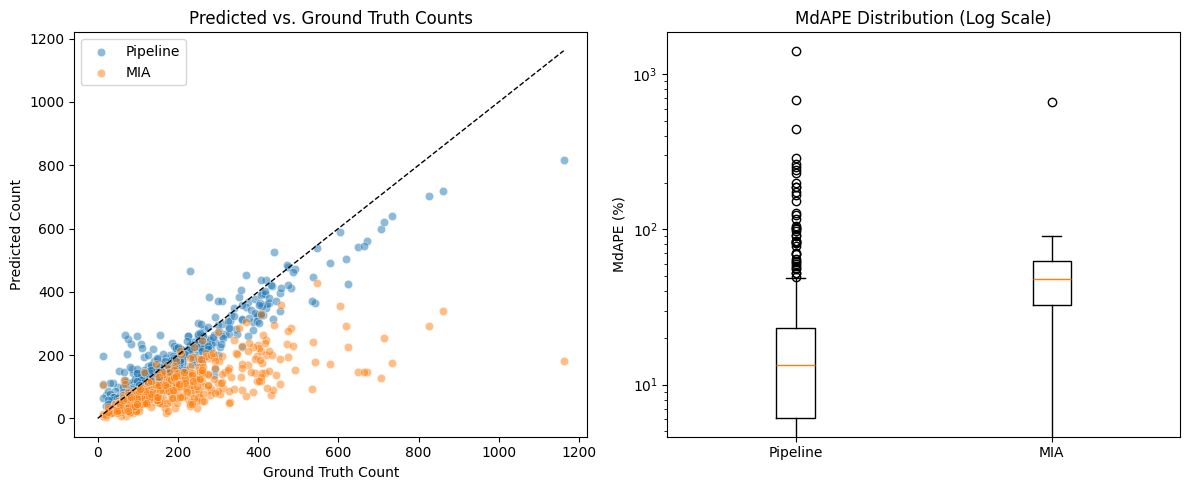

In [10]:
plt.figure(figsize=(12, 5))

# Scatter plot
plt.subplot(1, 2, 1)
sns.scatterplot(data=results_df, x="ground_truth_count", y="predicted_count", label="Pipeline", alpha=0.5)
sns.scatterplot(data=results_df, x="ground_truth_count", y="mia_count", label="MIA", alpha=0.5)
plt.plot([0, results_df["ground_truth_count"].max()], [0, results_df["ground_truth_count"].max()], 'k--', lw=1)
plt.xlabel("Ground Truth Count")
plt.ylabel("Predicted Count")
plt.title("Predicted vs. Ground Truth Counts")
plt.legend()

# Boxplot with log scale
plt.subplot(1, 2, 2)
plt.boxplot([results_df["mape_pipeline"].replace(float('inf'), np.nan).dropna(),
             results_df["mape_mia"].replace(float('inf'), np.nan).dropna()], labels=["Pipeline", "MIA"])
plt.yscale("log")
plt.ylabel("MdAPE (%)")
plt.title("MdAPE Distribution (Log Scale)")

plt.tight_layout()
plt.savefig("validation_plots.svg")
plt.show()

### **Mean Absolute Error (MAE)**
Mean Absolute Error (MAE) is a common metric in regression tasks that measures the average magnitude of errors between predicted and actual values. It is expressed in the same units as the target variable (here, ecDNA counts), making it straightforward to interpret in the context of the data. MAE is particularly useful for understanding the absolute deviation of predictions without considering their direction (over- or under-prediction).

The formula for MAE is: 
$$
\text{MAE}_{\text{pipeline}} = \frac{1}{n} \sum_{i=1}^{n} \left| \hat{y}_i - y_i \right|
$$

where:
$$
\begin{aligned}
n &:\ \text{number of samples (e.g., images)} \\
\hat{y}_i &:\ \text{predicted value (e.g., predicted ecDNA count) for the } i\text{-th sample} \\
y_i &:\ \text{actual (ground truth) value for the } i\text{-th sample}
\end{aligned}
$$


MAE quantifies the average error in predictions. A smaller MAE indicates that predictions are closer to the true values, reflecting higher accuracy.

### **Trimmed and Untrimmed MAE**

**Untrimmed MAE**: This metric calculates the average absolute error across all samples, including outliers. It provides a holistic view of performance but can be heavily influenced by extreme errors, such as when predictions deviate significantly from small ground truth values (e.g., predicting 50 when the true count is 5).

**Trimmed MAE**: By excluding the top and bottom 5% of absolute errors (retaining the central 90% of the data), trimmed MAE reduces the impact of outliers. This is valuable in datasets with high variability or rare extreme errors, offering a clearer picture of typical performance.

In [11]:
# Compute MAE (untrimmed and trimmed) for Pipeline and MIA
mae_pipeline = mean_absolute_error(results_df["predicted_count"], results_df["ground_truth_count"])
mae_mia = mean_absolute_error(results_df["mia_count"], results_df["ground_truth_count"])
trimmed_mae_pipeline = mean_absolute_error_with_trimming(results_df["predicted_count"], results_df["ground_truth_count"], trim_percent=5)
trimmed_mae_mia = mean_absolute_error_with_trimming(results_df["mia_count"], results_df["ground_truth_count"], trim_percent=5)

# Update summary table with MAE metrics
summary_df = pd.DataFrame({
    "Metric": ["MdAPE (%)", "Correlation", "MAE (Untrimmed)", "MAE (Trimmed, 90% Data)"],
    "Pipeline": [
        median_absolute_percentage_error(results_df["mape_pipeline"]),
        np.corrcoef(results_df["predicted_count"], results_df["ground_truth_count"])[0, 1]
        if results_df["predicted_count"].var() > 0 else np.nan,
        mae_pipeline,
        trimmed_mae_pipeline
    ],
    "MIA": [
        median_absolute_percentage_error(results_df["mape_mia"]),
        np.corrcoef(results_df["mia_count"], results_df["ground_truth_count"])[0, 1],
        mae_mia,
        trimmed_mae_mia
    ]
})
summary_df.to_csv("validation_summary.csv", index=False)

# Statistical test on absolute errors
abs_errors_pipeline = np.abs(results_df["predicted_count"] - results_df["ground_truth_count"])
abs_errors_mia = np.abs(results_df["mia_count"] - results_df["ground_truth_count"])
if len(abs_errors_pipeline) > 0 and len(abs_errors_mia) > 0:
    stat_abs, p_abs = wilcoxon(abs_errors_pipeline, abs_errors_mia, alternative='two-sided')
    print(summary_df)
    print(f"Wilcoxon test: statistic={stat}, p-value={p} (MAPE comparison)")
    print(f"Wilcoxon test on absolute errors: statistic={stat_abs}, p-value={p_abs} (MAE comparison)")
else:
    print(summary_df)
    print("Wilcoxon test skipped: insufficient valid values")

                    Metric   Pipeline         MIA
0                MdAPE (%)  13.314866   47.883244
1              Correlation   0.941456    0.717657
2          MAE (Untrimmed)  37.595361  112.878866
3  MAE (Trimmed, 90% Data)  31.619048   99.399425
Wilcoxon test: statistic=12455.5, p-value=1.266245341708267e-29 (MAPE comparison)
Wilcoxon test on absolute errors: statistic=7494.5, p-value=5.729449876611866e-42 (MAE comparison)


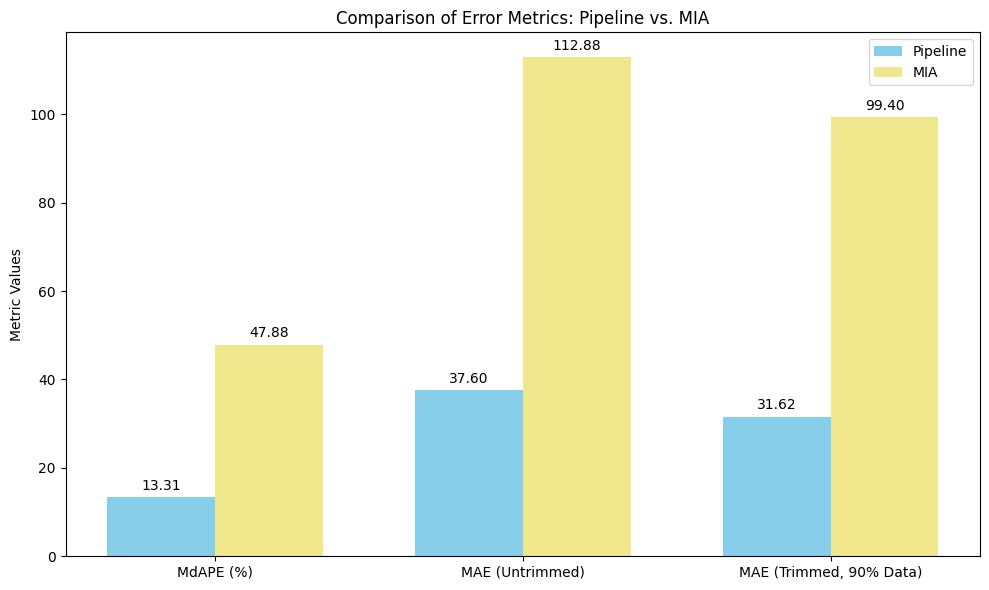

In [12]:
# Data for plotting
metrics = ['MdAPE (%)', 'MAE (Untrimmed)', 'MAE (Trimmed, 90% Data)']
pipeline_values = [13.314866, 37.595361, 31.619048]
mia_values = [47.883244, 112.878866, 99.399425]

# Set up the plot
x = np.arange(len(metrics))  # Label locations
width = 0.35  # Width of bars

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, pipeline_values, width, label='Pipeline', color='skyblue')
bars2 = ax.bar(x + width/2, mia_values, width, label='MIA', color='khaki')

# Customize the plot
ax.set_ylabel('Metric Values')
ax.set_title('Comparison of Error Metrics: Pipeline vs. MIA')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Add value labels on top of bars
for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # Offset above bar
                textcoords="offset points",
                ha='center', va='bottom')

plt.tight_layout()
plt.savefig("metrics_comparison.svg")
plt.show()

## **Results**

### **Validation Performance**
**Result:** The optimized ecDNA detection pipeline achieved a Median Absolute Percentage Error (MdAPE) of 13.31%, a Mean Absolute Error (MAE) of 37.60 counts (trimmed MAE: 31.62 counts, 90% data), and a correlation of 0.94 between predicted and ground truth counts across 388 images.

**Explanation:** The MdAPE of 13.31% indicates that the pipeline’s predictions deviate by ~13% from ground truth ecDNA counts, while the MAE of 37.60 counts (trimmed: 31.62 counts) shows an average absolute error of ~32–38 counts per image, demonstrating high accuracy. This MdAPE matches the optimization target from Notebook 1 (13.31%), confirming the robustness of the Bayesian-optimized parameters. The correlation of 0.94 reflects a strong linear relationship between predicted and ground truth counts, as seen in the scatter plot where pipeline predictions (blue dots) closely align with the ideal y=x line. The dataset of 388 images spans diverse groups (HIGH_HER2, LOW_HER2, TOTAL_HER2), ensuring a comprehensive evaluation.


### **Comparison with MIA**
**Result:** The pipeline significantly outperformed the MIA method, which yielded an MdAPE of 47.88%, an MAE of 112.88 counts (trimmed MAE: 99.40 counts, 90% data), and a correlation of 0.72, with Wilcoxon test p-values of 1.27e-29 (MAPE) and 5.73e-42 (MAE).

**Explanation:** The pipeline’s MdAPE (13.31%) and MAE (37.60, trimmed: 31.62) are over 3.5 times lower than MIA’s (MdAPE: 47.88%, MAE: 112.88, trimmed: 99.40), indicating superior accuracy in both relative and absolute terms. The correlation of 0.94 versus MIA’s 0.72 highlights the pipeline’s greater consistency, as MIA predictions (orange dots in the scatter plot) show larger deviations from the ground truth. Wilcoxon signed-rank tests (p-values: 1.27e-29 for MAPE, 5.73e-42 for MAE) confirm that the pipeline’s lower errors are statistically significant, rejecting the null hypothesis of no difference between the methods. This improvement stems from the pipeline’s optimized image enhancement and detection algorithms, which better handle variations in ecDNA counts.

### **Error Distribution and Outlier Analysis**
**Result:** The pipeline’s MAPE distribution is tighter (IQR: ~10% to 30%) compared to MIA (IQR: ~30% to 100%), with absolute error outliers up to 345 counts (pipeline) and 536 counts (MIA); trimming reduces MAE by 16% (pipeline) and 12% (MIA).

**Explanation:** The boxplot (log scale) shows the pipeline’s per-image MAPE values are more concentrated (IQR: ~10% to 30%) than MIA’s (IQR: ~30% to 100%), indicating greater consistency. Absolute errors reveal outliers, such as 345 counts for the pipeline (ground truth: 1162, predicted: 817) and 536 counts for MIA (ground truth: 827, predicted: 291), often due to small ground truth counts or mispredictions. Trimming the top and bottom 5% of absolute errors reduces the pipeline’s MAE by 16% (37.60 to 31.62) and MIA’s by 12% (112.88 to 99.40), highlighting the pipeline’s robustness. The use of MdAPE (median) and trimmed MAE ensures focus on typical errors (13.31% MdAPE, 31.62 trimmed MAE for the pipeline), critical for ecDNA detection where count variability can skew mean-based metrics.

### Reproducibility Notes

- **Data Availability**: Ground truth (`GT.csv`), MIA predictions (`output_mia.csv`), and images are availabor upon request from the corresponding author.
- **Execution**: Adjust paths (`RGB_FOLDER`, `DAPI_FOLDER`, etc.) to your system. Run cells sequentially after installing dependenciing.
- **Output**: Results are saved as `validation_results.csv`, `validation_summary.csv`, and `validation_plots.svg`.

## Acknowledgment

**Use of AI-Based Code Generation and Editing Tools**  
This project was enhanced by the use of AI tools—ChatGPT, Grok, and Copilot—which played significant roles in improving the code, explanations, and overall presentation of the work.

### Specific Contributions

- **ChatGPT**:
  - Added comments to various functions to improve code readability and understanding.
  - Assisted in optimizing functions and replacing less effective ones, leading to better performance and results.
  - Proposed new error metrics for removing outliers, including the use of Trimmed and Untrimmed MAE .
  - Provided clear, simplified explanations of complex concepts to make the content more accessible.
  - Edited text for grammatical accuracy, clarity, and an appropriate tone.

- **Grok**:
  - Contributed to adding comments to functions for better documentation.
  - Helped optimize functions and suggested replacements that improved the project’s outcomes.
  - Assisted in refining explanations to ensure they were concise and easy to understand.


All three tools—ChatGPT, Grok, and Copilot—were used to simplify explanations, making them clearer and more accessible. They also assisted in editing the grammar and tone of the text to improve readability and professionalism.

- **Iterative Refinement Process:**
For most parts of this project, I provided the same prompts to ChatGPT, Grok, and Copilot to compare their responses. I then asked each tool to evaluate the outputs of the others and provide feedback. This feedback was shared back with the tools, allowing them to refine their suggestions iteratively. This process ensured that the final code, explanations, and results were optimized for accuracy, clarity, and effectiveness.

### Citations

- OpenAI. (2023). ChatGPT (Version o3-mini-high for code and logics & Version 4.5 for text editing) Large language model. https://openai.com/chatgpt
- Grok (2023). xAI.(Version 3.0). Used for text generation and code refinement in this project. https://xai.com/grok
- Microsoft Copilot (an AI assistant developed by Microsoft),



